---

Travel Time Matrix 

---

In [ ]:
import os
import subprocess
import sys
from pathlib import Path

# === USER SETTINGS ===
working_dir = str(Path().absolute())                # Set your working directory
points_file = "B4m_com_ll.shp"                      # Point shapefile (origins/destinations)
#stations_file = None                                # Set to None or "" to auto-generate stations
stations_file = "UBahn2020_stops_ll.shp"           # Set to None or "" to auto-generate stations

network_file = "berlin_trainline.shp"               # Network polyline shapefile
point_id_field = "STAT_BLOCK"                       # Identifier field in point shapefile
walking_speed_kmh = 5                               # Walking speed (km/h)
network_speed_kmh = 25                              # Network speed (km/h)
snap_tolerance_m = 1.0                              # Tolerance for snapping network segment endpoints (meters)
output_matrix_file = "TTMATRIX_berlin_trainline.csv"            # Output travel time matrix CSV
output_shapefile = "ATT_berlin_trainline.shp"                   # Output shapefile with average travel times
output_edges_shapefile = "graph_edges_berlin_trainline.shp"     # Output shapefile showing the graph (network + walking) used in Dijkstra
# --- Only relevant if no station shapefile is provided ---
cluster_eps_m = 200                                 # Max distance between points in a cluster for artificial stations (meters)
# --- Optional for debugging ---
debug_limit_points = None                           # Set to e.g. 1000 to limit to first N points for testing

In [74]:
# === PACKAGE INSTALLATION ===
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg in ["geopandas", "shapely", "tqdm", "matplotlib", "networkx", "pandas", "numpy", "pyproj", "scipy", "scikit-learn"]:
    try:
        __import__(pkg)
    except ImportError:
        install(pkg)

# === IMPORTS ===
import geopandas as gpd
from shapely.geometry import LineString, Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from pyproj import CRS
from scipy.spatial import cKDTree
from shapely.ops import split
from sklearn.cluster import DBSCAN

In [75]:
# === SET PATHS ===
input_dir = os.path.join(working_dir, "input")
output_dir = os.path.join(working_dir, "output")
os.makedirs(output_dir, exist_ok=True)

points_path = os.path.join(input_dir, points_file)
stations_path = os.path.join(input_dir, stations_file) if stations_file else None
network_path = os.path.join(input_dir, network_file)

# === LOAD DATA ===
points = gpd.read_file(points_path)
if debug_limit_points is not None:
    print(f"Limiting points to the first {debug_limit_points} for testing...")
    points = points.iloc[:debug_limit_points].copy()

network = gpd.read_file(network_path)

# === CHECK & ALIGN CRS ===
if not points.crs.is_projected:
    print(f"Input CRS: {points.crs}")
    print("Points file is in geographic coordinates. Reprojecting to a local UTM CRS...")

    centroid = points.geometry.union_all().centroid
    zone_number = int((centroid.x + 180) / 6) + 1
    is_northern = centroid.y >= 0
    epsg_code = 32600 + zone_number if is_northern else 32700 + zone_number
    best_utm_crs = CRS.from_epsg(epsg_code)

    print(f"Reprojecting to UTM zone {zone_number}, EPSG:{epsg_code}")

    points = points.to_crs(best_utm_crs)
    network = network.to_crs(best_utm_crs)
else:
    network = network.to_crs(points.crs)

Input CRS: EPSG:4326
Points file is in geographic coordinates. Reprojecting to a local UTM CRS...
Reprojecting to UTM zone 33, EPSG:32633


In [76]:
# === HANDLE STATIONS: load or generate ===
def generate_artificial_stations(points, network, eps=200):
    print("No station shapefile found. Generating artificial stations using DBSCAN clustering...")

    coords = np.array([[geom.x, geom.y] for geom in points.geometry])
    clustering = DBSCAN(eps=eps, min_samples=1).fit(coords)
    labels = clustering.labels_
    centroids = []

    for label in np.unique(labels):
        cluster_coords = coords[labels == label]
        centroid_xy = cluster_coords.mean(axis=0)
        centroid_point = Point(centroid_xy)

        distances = network.geometry.distance(centroid_point)
        nearest_idx = distances.idxmin()
        nearest_line = network.geometry.loc[nearest_idx]
        projected = nearest_line.interpolate(nearest_line.project(centroid_point))
        centroids.append(projected)

    stations = gpd.GeoDataFrame(geometry=centroids, crs=points.crs)
    print(f"Generated {len(stations)} artificial stations.")
    return stations

if stations_path and os.path.exists(stations_path):
    stations = gpd.read_file(stations_path).to_crs(points.crs)
else:
    stations = generate_artificial_stations(points, network, eps=cluster_eps_m)

print(f"Loaded {len(points)} points")
print(f"Loaded {len(stations)} stations")
print(f"Loaded {len(network)} network elements")

Loaded 12309 points
Loaded 319 stations
Loaded 410 network elements


In [77]:
# === SNAP NEARBY ENDPOINTS IN NETWORK ===
if snap_tolerance_m > 0:
    print(f"Snapping nearby network segment endpoints within {snap_tolerance_m} meter(s)...")

    endpoints = []
    for geom in network.geometry:
        coords = list(geom.coords)
        if len(coords) >= 2:
            endpoints.append(Point(coords[0]))
            endpoints.append(Point(coords[-1]))

    endpoint_coords = np.array([[pt.x, pt.y] for pt in endpoints])
    endpoint_kdtree = cKDTree(endpoint_coords)
    snapped_coords = endpoint_coords.copy()
    visited = set()

    for i in range(len(endpoint_coords)):
        if i in visited:
            continue
        idxs = endpoint_kdtree.query_ball_point(endpoint_coords[i], r=snap_tolerance_m)
        if len(idxs) > 1:
            visited.update(idxs)
            cluster_pts = endpoint_coords[idxs]
            centroid = cluster_pts.mean(axis=0)
            for idx in idxs:
                snapped_coords[idx] = centroid

    coord_map = {tuple(pt): tuple(snapped_coords[i]) for i, pt in enumerate(endpoint_coords)}

    def snap_coords(coords):
        return [coord_map.get(tuple(c), c) for c in coords]

    snapped_geoms = []
    for geom in network.geometry:
        coords = list(geom.coords)
        new_coords = snap_coords(coords)
        snapped_geoms.append(LineString(new_coords))

    network["geometry"] = snapped_geoms
    print("Finished snapping network endpoints.")

# === SPLIT NETWORK SEGMENTS AT STATION LOCATIONS IF THEY PASS THROUGH ===
print("Splitting network lines at stations if they pass through...")

station_buffer = stations.copy()
station_buffer["geometry"] = station_buffer.buffer(0.5)

Snapping nearby network segment endpoints within 1.0 meter(s)...
Finished snapping network endpoints.
Splitting network lines at stations if they pass through...


In [78]:
new_geoms = []

for line in tqdm(network.geometry, desc="Splitting lines"):
    intersecting_stations = station_buffer[station_buffer.intersects(line)]

    if intersecting_stations.empty:
        new_geoms.append(line)
    else:
        splitters = intersecting_stations["geometry"].union_all()
        try:
            result = split(line, splitters)
            for segment in result.geoms:
                if segment.length > 0:
                    new_geoms.append(segment)
        except Exception as e:
            print(f"Warning: could not split line: {e}")
            new_geoms.append(line)

Splitting lines: 100%|██████████| 410/410 [00:00<00:00, 1034.21it/s]


In [79]:
network = gpd.GeoDataFrame(geometry=new_geoms, crs=points.crs)
print(f"Finished splitting. Network now has {len(network)} segments.")

# === CENTROID CONVERSION IF NEEDED ===
if points.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    print("Converting polygons to centroids...")
    points["geometry"] = points.centroid

# === BUILD AUGMENTED GRAPH ===
print("Building augmented graph with transit + walking...")

G_aug = nx.Graph()

# Add transit network edges
for idx, row in network.iterrows():
    coords = list(row.geometry.coords)
    for i in range(len(coords) - 1):
        u, v = coords[i], coords[i + 1]
        segment = LineString([u, v]).length
        time = (segment / 1000) / network_speed_kmh * 60
        G_aug.add_edge(u, v, weight=time)

# Add station nodes
for idx, row in stations.iterrows():
    G_aug.add_node(f"station_{idx}", geometry=row.geometry)

# === CONNECT STATIONS TO TRANSIT NETWORK ===
print("Connecting stations to nearest transit network node...")

network_nodes = [n for n in G_aug.nodes if isinstance(n, tuple)]
network_node_points = [Point(n) for n in network_nodes]
network_kdtree = cKDTree(np.array([[pt.x, pt.y] for pt in network_node_points]))

for idx, row in tqdm(stations.iterrows(), total=len(stations), desc="Snapping stations"):
    station_name = f"station_{idx}"
    station_coord = np.array([row.geometry.x, row.geometry.y])
    _, nearest_idx = network_kdtree.query(station_coord, k=1)
    nearest_node = network_nodes[nearest_idx]
    G_aug.add_edge(station_name, nearest_node, weight=0.0001)

# Add point nodes
for idx, row in points.iterrows():
    G_aug.add_node(f"point_{idx}", geometry=row.geometry)

# === CONNECT POINTS TO NEAREST STATIONS ===
print("Adding walking edges from points to their 3 nearest stations...")

station_coords = np.array([[geom.x, geom.y] for geom in stations.geometry])
station_kdtree = cKDTree(station_coords)

point_coords = np.array([[geom.x, geom.y] for geom in points.geometry])

for i in tqdm(range(len(points)), desc="Point-to-station edges"):
    distances, indices = station_kdtree.query(point_coords[i], k=3)
    p_node = f"point_{i}"
    for dist_m, j in zip(distances, indices):
        s_node = f"station_{j}"
        time_min = (dist_m / 1000) / walking_speed_kmh * 60
        G_aug.add_edge(p_node, s_node, weight=time_min)

# === ADD WALKING EDGES TO NEAREST NEIGHBORS ONLY ===
print("Adding walking edges to 5 nearest neighbors per point...")

point_kdtree = cKDTree(point_coords)

for i in tqdm(range(len(points)), desc="Point-to-point nearest neighbors"):
    distances, neighbors = point_kdtree.query(point_coords[i], k=6)
    p_node_i = f"point_{i}"
    for neighbor_idx, distance_m in zip(neighbors[1:], distances[1:]):
        p_node_j = f"point_{neighbor_idx}"
        time_min = (distance_m / 1000) / walking_speed_kmh * 60
        G_aug.add_edge(p_node_i, p_node_j, weight=time_min)

# === COMPUTE TRAVEL TIME MATRIX (SERIAL) ===
print("Computing travel time matrix (serial)...")
matrix = pd.DataFrame(index=points.index, columns=points.index)

for i in tqdm(points.index, desc="Dijkstra"):
    source = f"point_{i}"
    lengths = nx.single_source_dijkstra_path_length(G_aug, source, weight='weight')
    for j in points.index:
        target = f"point_{j}"
        matrix.at[i, j] = lengths.get(target, np.nan)

# === ASSIGN ID LABELS WITH PREFIX TO MATRIX ===
if point_id_field not in points.columns:
    raise ValueError(f"ID field '{point_id_field}' not found in points file.")

id_labels = points[point_id_field].astype(str).values
row_labels = [point_id_field + str(val) for val in id_labels]
matrix.index = row_labels
matrix.columns = row_labels

# === SAVE MATRIX TO CSV ===
output_csv = os.path.join(output_dir, output_matrix_file)
matrix.to_csv(output_csv, index_label=point_id_field)
print(f"Saved matrix to: {output_csv}")

# === COMPUTE MEAN TRAVEL TIME ===
mean_travel_times = matrix.mean(axis=1, skipna=True)
points["mean_time_min"] = pd.to_numeric(mean_travel_times.values, errors='coerce').astype("float64")

# === SAVE POINTS WITH MEAN TIME ===
points_out_path = os.path.join(output_dir, output_shapefile)
points.to_file(points_out_path)
print(f"Saved enriched points with mean travel times to: {points_out_path}")

# === EXPORT ALL GRAPH EDGES AS SHAPEFILE (INCLUDING POINT & STATION LINKS) ===
print("Exporting full graph edges (network + walking) as shapefile...")

edge_records = []

for u, v, data in G_aug.edges(data=True):
    try:
        geom_u = Point(u) if isinstance(u, tuple) else G_aug.nodes[u]["geometry"]
        geom_v = Point(v) if isinstance(v, tuple) else G_aug.nodes[v]["geometry"]
        line = LineString([geom_u, geom_v])
        edge_records.append({
            "from_node": str(u),
            "to_node": str(v),
            "time_min": data["weight"],
            "geometry": line
        })
    except Exception as e:
        print(f"Skipped edge ({u}, {v}): {e}")

edges_gdf = gpd.GeoDataFrame(edge_records, crs=points.crs)
edges_out_path = os.path.join(output_dir, output_edges_shapefile)
edges_gdf.to_file(edges_out_path)
print(f"Saved graph edges to: {edges_out_path}")

Finished splitting. Network now has 1044 segments.
Building augmented graph with transit + walking...
Connecting stations to nearest transit network node...


Snapping stations: 100%|██████████| 319/319 [00:00<00:00, 11213.96it/s]


Adding walking edges from points to their 3 nearest stations...


Point-to-station edges: 100%|██████████| 12309/12309 [00:00<00:00, 41506.96it/s]


Adding walking edges to 5 nearest neighbors per point...


Point-to-point nearest neighbors: 100%|██████████| 12309/12309 [00:00<00:00, 30885.82it/s]


Computing travel time matrix (serial)...


Dijkstra: 100%|██████████| 12309/12309 [51:17<00:00,  4.00it/s] 


Saved matrix to: c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration\experiments\output\TTMATRIX_berlin_trainline.csv


C:\Users\lfelder\AppData\Local\Temp\ipykernel_13712\3388097615.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(points_out_path)
C:\Users\lfelder\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_time_min' to 'mean_time_'
  ogr_write(


Saved enriched points with mean travel times to: c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration\experiments\output\ATT_berlin_trainline.shp
Exporting full graph edges (network + walking) as shapefile...
Saved graph edges to: c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration\experiments\output\graph_edges_berlin_trainline.shp


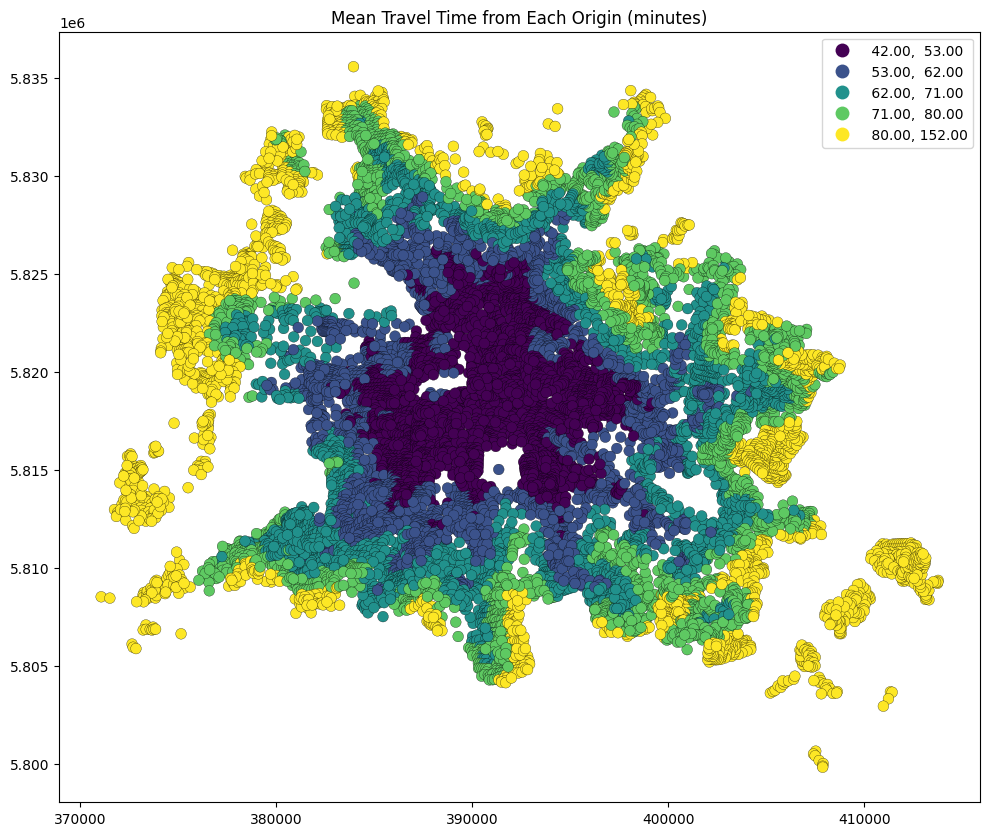


Mean travel time statistics (in minutes):
Mean: 68.47
Min:  42.00
Max:  152.00


In [80]:
points = gpd.read_file(points_out_path)
points['mean_time_'] = points['mean_time_'].round()

# === PLOT MEAN TRAVEL TIME MAP ===
fig, ax = plt.subplots(figsize=(10, 10))
points.plot(
    column="mean_time_",
    ax=ax,
    legend=True,
    cmap="viridis",
    markersize=60,
    edgecolor="black",
    linewidth=0.2, 
    scheme="quantiles", 
)
plt.title("Mean Travel Time from Each Origin (minutes)")
plt.tight_layout()
plt.show()
ax.set_axis_off()

# === STATISTICS FOR MEAN TRAVEL TIMES ===
print("\nMean travel time statistics (in minutes):")
print(f"Mean: {points['mean_time_'].mean():.2f}")
print(f"Min:  {points['mean_time_'].min():.2f}")
print(f"Max:  {points['mean_time_'].max():.2f}")

In [81]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

block_file = f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/Berlin4matlab.shp'

# --- Block centroids ---
gdf_berlin = gpd.read_file(block_file).to_crs(3035)

c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration


In [82]:
gdf_berlin_network = gpd.read_file(network_path)

In [83]:
gdf_berlin_water = gpd.read_file(f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/BerlinWater.shp').to_crs(3035)
gdf_berlin_green = gpd.read_file(f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/BerlinGreen.shp').to_crs(3035)

# [30, 106, 178]  # U-Bahn
# [0, 114, 56]    # S-Bahn
# #%02x%02x%02x' % (30, 106, 178)

In [84]:
gdf_berlin_network

,Id,Length,Minutes,transport_,path,geometry
0,0,1392.904994,3.342972,sbahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (10587.903 11594.979, 10549.709 115..."
1,0,773.517604,1.856442,sbahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (16822.359 19366.262, 16575.946 192..."
2,0,563.203391,1.351688,sbahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (24857.809 24734.145, 24747.548 247..."
3,0,799.830287,1.919593,sbahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (24857.809 24734.145, 24850.907 247..."
4,0,891.179743,2.138831,sbahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (24296.886 24720.56, 24348.116 2473..."
...,...,...,...,...,...,...
405,0,1208.227206,2.899745,ubahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (31213.226 9847.479, 31137.855 9898..."
406,0,429.365469,1.030477,ubahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (22937.253 19185.189, 22942.289 192..."
407,0,666.574625,1.599779,ubahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (22977.402 19609.769, 22985.352 196..."
408,0,22.565834,0.054158,ubahn,C:\Users\lfelder\OneDrive - DIW Berlin\Spatial...,"LINESTRING (23537.48 19090.41, 23537.216 19112..."


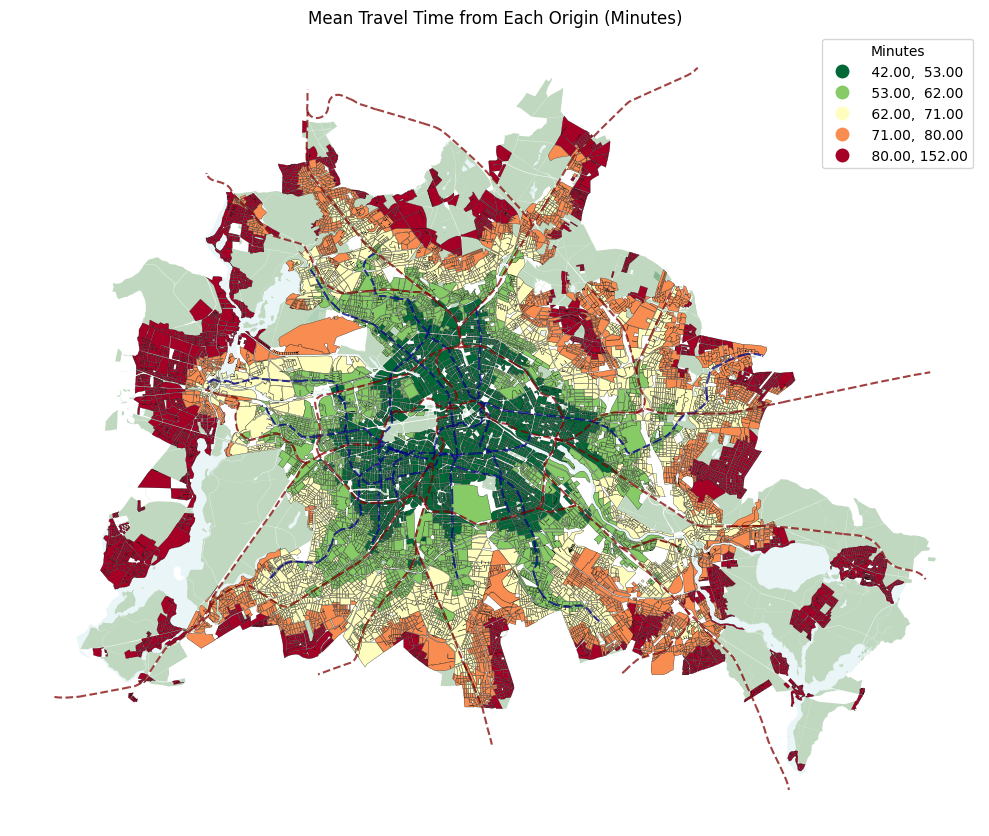

In [85]:
points = gpd.read_file(points_out_path)
points['mean_time_'] = points['mean_time_'].round()

# === PLOT MEAN TRAVEL TIME MAP ===
fig, ax = plt.subplots(figsize=(10, 10))

gdf_berlin_network.loc[gdf_berlin_network['transport_'] == 'ubahn'].to_crs(3035).plot(
    ax=ax, edgecolor='navy', label='U-Bahn Network', legend=True, linestyle='--', alpha=0.75)
gdf_berlin_network.loc[gdf_berlin_network['transport_'] == 'sbahn'].to_crs(3035).plot(
    ax=ax, edgecolor='maroon', label='S-Bahn Network', legend=True, linestyle='--', alpha=0.75)
#leg1 = ax.get_legend() # save the legend from the first plot

gdf_berlin_water.to_crs(3035).plot(ax=ax, color="lightblue", label='Water', legend=True, alpha=0.25)
gdf_berlin_green.to_crs(3035).plot(ax=ax, color="darkgreen", label='Vegetation', legend=True, alpha=0.25)

pd.concat([gdf_berlin, points.drop(columns=['geometry'])], axis=1).plot(
    column="mean_time_",
    ax=ax,
    legend=True,
    cmap="RdYlGn_r",
    markersize=60,
    edgecolor="black",
    linewidth=0.2, 
    scheme="quantiles", 
    # legend_kwds=dict(loc='lower left', title='Minutes', bbox_to_anchor=(0.05, -0.05), ncol=5)
    legend_kwds=dict(loc='upper right', title='Minutes', ncol=1)
)
#ax.add_artist(leg1) # add the first legend back in

# edges_gdf.to_crs(3035).plot(
#     ax=ax,
#     edgecolor="black",
#     linewidth=0.1, 
# )

plt.title("Mean Travel Time from Each Origin (Minutes)")
ax.set_axis_off()
plt.tight_layout()

In [86]:
# === STATISTICS FOR MEAN TRAVEL TIMES ===
print("\nMean travel time statistics (in minutes):")
print(f"Mean: {points['mean_time_'].mean():.2f}")
print(f"Min:  {points['mean_time_'].min():.2f}")
print(f"Max:  {points['mean_time_'].max():.2f}")


Mean travel time statistics (in minutes):
Mean: 68.47
Min:  42.00
Max:  152.00


Comments: 

- Add info on python version and requirements file
- I like the use of the tqdm package
- I like the use of networkx instead of igraph
- Line 169: unary_union instead of union_all()


- Restrict to 30 minutes from center 
- Prominent modes of transport 
- Travel Distance vs Luftliftlinie by travel time / mode of transport
- Time vs Distance by Mode 
- Save the shortest paths to list points that are crossed the most (commuting hubs)
- Fully integrated network allevites poor connectivity in the outskirts 

-> Analyze connectivity HUBs in rural areas 

---